In [100]:
# Step 0: Importing libraries
import pandas as pd
import sqlite3
import argparse
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [65]:
# Step 1: Extract data

sales_A = pd.read_csv('/Users/hosseind/Downloads/case/sales_region_A.csv')
sales_B = pd.read_csv('/Users/hosseind/Downloads/case/sales_region_B.csv')
product_ids = pd.read_csv('/Users/hosseind/Downloads/case/product_details.csv')

In [66]:
# Step 2: Cleansing

sales = pd.concat([sales_A, sales_B], ignore_index=True) # joining regions was not asked in the code!!! I did it to avoid duplication

sales['Quantity'].fillna(sales['Quantity'].mean().round(), inplace=True)
sales['Price'].fillna(sales['Price'].mean().round(), inplace=True)
# there were missing values in 'ProductID' which not mentioned in the task to to deal with!!!
sales['ProductID'].fillna(sales['ProductID'].interpolate(), inplace=True) 
sales.head()

,TransactionID,Date,ProductID,Quantity,Price
0,1001,01/15/2021,101.0,2.0,19.99
1,1002,02/20/2021,102.0,1.0,29.99
2,1003,03/25/2021,103.0,5.0,9.99
3,1004,04/30/2021,104.0,3.0,14.99
4,1005,05/05/2021,105.0,2.0,49.99


In [67]:
# Step 3: Transformation

# Since two date formats existed in two regions
sales['Date'] = pd.to_datetime(sales['Date'], format='%m/%d/%Y', errors='coerce') .combine_first(
    pd.to_datetime(sales['Date'], format='%d-%m-%Y', errors='coerce'))

sales['Year'] = sales['Date'].dt.year
sales['Month'] = sales['Date'].dt.month
sales.head()

,TransactionID,Date,ProductID,Quantity,Price,Year,Month
0,1001,2021-01-15,101.0,2.0,19.99,2021,1
1,1002,2021-02-20,102.0,1.0,29.99,2021,2
2,1003,2021-03-25,103.0,5.0,9.99,2021,3
3,1004,2021-04-30,104.0,3.0,14.99,2021,4
4,1005,2021-05-05,105.0,2.0,49.99,2021,5


In [68]:
# Step 4: Enrichment/Combining
sales = sales.merge(product_ids, on='ProductID', how='left')
sales.head()

,TransactionID,Date,ProductID,Quantity,Price,Year,Month,ProductName,Category
0,1001,2021-01-15,101.0,2.0,19.99,2021,1,Gizmo,A
1,1002,2021-02-20,102.0,1.0,29.99,2021,2,Widget,A
2,1003,2021-03-25,103.0,5.0,9.99,2021,3,Thingamajig,B
3,1004,2021-04-30,104.0,3.0,14.99,2021,4,Doodad,B
4,1005,2021-05-05,105.0,2.0,49.99,2021,5,Whatsit,C


In [69]:
# Step 5: calculate total sales
sales['TotalSales'] = sales['Quantity'] * sales['Price']
sales.head()

,TransactionID,Date,ProductID,Quantity,Price,Year,Month,ProductName,Category,TotalSales
0,1001,2021-01-15,101.0,2.0,19.99,2021,1,Gizmo,A,39.98
1,1002,2021-02-20,102.0,1.0,29.99,2021,2,Widget,A,29.99
2,1003,2021-03-25,103.0,5.0,9.99,2021,3,Thingamajig,B,49.95
3,1004,2021-04-30,104.0,3.0,14.99,2021,4,Doodad,B,44.97
4,1005,2021-05-05,105.0,2.0,49.99,2021,5,Whatsit,C,99.98


In [70]:
# Step 6: aggregation

report_cat = sales.groupby(['Category'])['TotalSales'].sum().reset_index() # per Category 
report_date = sales.groupby(['Year', 'Month'])['TotalSales'].sum().reset_index() # per Year and Month
print(report_cat)
print(report_date)

  Category  TotalSales
0        A       69.97
1        B       94.92
2        C      149.96
3        D      295.98
4        E      119.96
5        F      199.97
6        G      209.96
7        H      519.94
8        I      233.98
9        J      169.93
   Year  Month  TotalSales
0  2021      1      139.97
1  2021      2      129.97
2  2021      3      199.94
3  2021      4      104.94
4  2021      5      219.94
5  2021      6      449.96
6  2021      7      395.98
7  2021      8      133.98
8  2021      9      109.92
9  2021     10      179.97


In [71]:
# Step 7: Data Loading part

DATABASE_PATH = '/Users/hosseind/Downloads/case/sales.db'

connect = sqlite3.connect(DATABASE_PATH)
report_cat.to_sql('report_cat', connect, if_exists='replace', index=False)
report_date.to_sql('report_date', connect, if_exists='replace', index=False)

connect.close()

In [72]:
# Run SQL-requests against the database to get tables info
connect = sqlite3.connect(DATABASE_PATH)

cursor = connect.cursor()
cursor.execute("SELECT count(*) FROM sqlite_master WHERE type='table';")
table_count = cursor.fetchone()[0]
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print(f'Total tables in the database: {table_count}')
for table in tables:
    cursor.execute(f"PRAGMA table_info({table[0]})")
    column_info = cursor.fetchall()
    column_names = [info[1] for info in column_info]
    print(table[0])
    print(column_names)
    
df = pd.read_sql_query(f"SELECT * from report_date", connect) # or {table[0]}
print(df.head())

connect.close()

Total tables in the database: 2
report_cat
['Category', 'TotalSales']
report_date
['Year', 'Month', 'TotalSales']
   Year  Month  TotalSales
0  2021      1      139.97
1  2021      2      129.97
2  2021      3      199.94
3  2021      4      104.94
4  2021      5      219.94


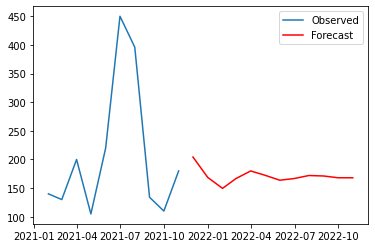

In [98]:
# Step ML: Sales Forecast

sales2 = sales.copy()
sales2.set_index('Date', inplace=True)

monthly_sales = sales2['TotalSales'].resample('M').sum()

model = ARIMA(monthly_sales, order=(2, 1, 0))  
arima_result = model.fit()

forecast = arima_result.forecast(steps=12) # 12 months forecast

# Plot the forecast
plt.plot(monthly_sales.index, monthly_sales, label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

In [73]:
# make SQL database

DATABASE_PATH = '/Users/hosseind/Downloads/case/SQLdb.db'

connect = sqlite3.connect(DATABASE_PATH)
sales_A.to_sql('sales_A', connect, if_exists='replace', index=False)
sales_B.to_sql('sales_B', connect, if_exists='replace', index=False)
product_ids.to_sql('product_ids', connect, if_exists='replace', index=False)

connect.close()

In [104]:
!python dn_media_pipeline.py --sales_A /Users/hosseind/Downloads/case/sales_region_A.csv --sales_B /Users/hosseind/Downloads/case/sales_region_A.csv --product_ids /Users/hosseind/Downloads/case/product_details.csv --database /Users/hosseind/Downloads/case/sales.db 



2024-10-06 11:54:11,212 - INFO - Step 1: Extract data
2024-10-06 11:54:11,213 - INFO - Successfully loaded file: /Users/hosseind/Downloads/case/sales_region_A.csv
2024-10-06 11:54:11,213 - INFO - Successfully loaded file: /Users/hosseind/Downloads/case/sales_region_A.csv
2024-10-06 11:54:11,214 - INFO - Successfully loaded file: /Users/hosseind/Downloads/case/product_details.csv
2024-10-06 11:54:11,216 - INFO - Step 2&3: Data cleaned & transformed successfully. Sales_data:
2024-10-06 11:54:11,219 - INFO - Step4: Data enriched successfully. Enriched data:
2024-10-06 11:54:11,220 - INFO - Step5: Data aggregated successfully. Aggregated_data:
2024-10-06 11:54:11,224 - INFO - Step6: Data loaded to database successfully. reports:
  Category  TotalSales
0        A      139.94
1        B      189.84
2        C      349.90
3        D      399.96
4        E      239.92
   Year  Month  TotalSales
0  2021      1       79.96
1  2021      2       59.98
2  2021      3       99.90
3  2021      4     

In [140]:
!crontab -e
!59 19 * * * /Users/hosseind/miniforge3/bin/python3 /Users/hosseind/Downloads/dn_media_pipeline.py --sales_A /Users/hosseind/Downloads/case/sales_region_A.csv --sales_B /Users/hosseind/Downloads/case/sales_region_A.csv --product_ids /Users/hosseind/Downloads/case/product_details.csv --database /Users/hosseind/Downloads/case/sales.db 


crontab: no crontab for hosseind - using an empty one
7[>4;2m="/tmp/crontab.R5yakpncPq" 0L, 0B▽  Pzz\[0%m           [>c]10;?]11;?~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                           